### Imports

In [1]:
#Base
import pandas as pd
import numpy as np

#others

import itertools
import string
import re

#Visuals
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

#warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
#sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.decomposition import NMF
from sklearn.manifold import TSNE

In [3]:
#nltk
import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer, sent_tokenize
from nltk.stem import PorterStemmer, SnowballStemmer, LancasterStemmer
from nltk import WordNetLemmatizer, pos_tag

### CSV File - EDA

In [4]:
#loading csv file

df = pd.read_csv('/Users/kellyjara/Desktop/Project_4/Data/judge-1377884607_tweet_product_company.csv', 
                encoding='latin-1')
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [5]:
# Viewing columns and null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [6]:
# Renaming column for easier callback/reference

df.rename(columns = {'is_there_an_emotion_directed_at_a_brand_or_product':'emotion'}, inplace = True)

In [7]:
# Renaming value in emotion column

df['emotion'] = df['emotion'].str.replace('No emotion toward brand or product', 'No emotion')


In [8]:
#Viewing change 

df.head()

,tweet_text,emotion_in_tweet_is_directed_at,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [9]:
#checking NaN values in columns

df.isna().sum()

tweet_text                            1
emotion_in_tweet_is_directed_at    5802
emotion                               0
dtype: int64

In [10]:
# Dropping column as it is not needed for sentiment analysis

df.drop(columns = 'emotion_in_tweet_is_directed_at', inplace = True)

In [11]:
# Dropping NaN values in the df
df.dropna(axis = 0, inplace = True)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9092 entries, 0 to 9092
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweet_text  9092 non-null   object
 1   emotion     9092 non-null   object
dtypes: object(2)
memory usage: 213.1+ KB


In [13]:
df['emotion'].value_counts()

No emotion          5388
Positive emotion    2978
Negative emotion     570
I can't tell         156
Name: emotion, dtype: int64

In [14]:
# Dropping values that contain cant tell emotion; Keeping only positive, negative, and no emotions
df2 = df[df['emotion'] != "I can't tell"]

In [15]:
df2['emotion'].value_counts()

No emotion          5388
Positive emotion    2978
Negative emotion     570
Name: emotion, dtype: int64

In [16]:
# Creating emotion column into a numerical value
df2['target'] = df2['emotion'].astype('category')
categories = ['No emotion','Positive emotion', 'Negative emotion']
df2['target'] = df2['target'].cat.reorder_categories(categories)
df2['target'] = df2['target'].cat.codes
df2['target'].value_counts()

0    5388
1    2978
2     570
Name: target, dtype: int64

In [17]:
# Viewing 1st tweet in the df 
tweet_1 = df['tweet_text'].iloc[0]
tweet_1

'.@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.'

<Axes: xlabel='emotion', ylabel='count'>

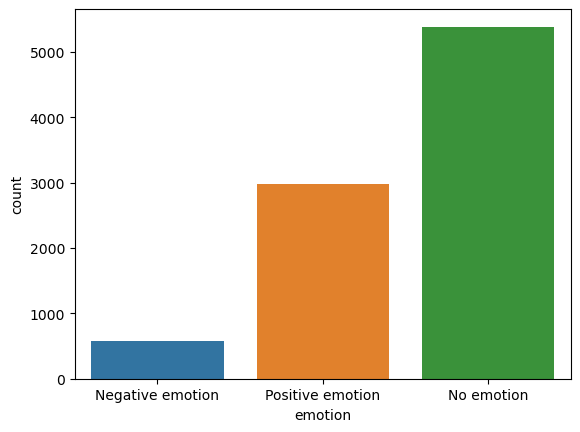

In [18]:
#Visualization of data distribution
sns.countplot(x = 'emotion', data = df2)

### Text PreProcessing 

In [106]:
def process_tweet(tweet_text, min_length):
    
    # get common stop words that we'll remove during tokenization/text normalization
    stop_words = stopwords.words('english')

    #initialize lemmatizer
    wnl = WordNetLemmatizer()

    # helper function to change nltk's part of speech tagging to a wordnet format.
    def pos_tagger(nltk_tag):
        if nltk_tag.startswith('JJ'):
            return wordnet.ADJ
        elif nltk_tag.startswith('VB'):
            return wordnet.VERB
        elif nltk_tag.startswith('NN'):
            return wordnet.NOUN
        elif nltk_tag.startswith('RB'):
            return wordnet.ADV
        else:         
            return None
   

    # lower case everything
    tweet_lower = tweet_text.lower()

    #remove mentions, hashtags, and urls, strip whitspace and breaks
    tweet_lower = re.sub(r"@[a-z0-9_]+|#[a-z0-9_]+|http\S+", "", 
                         tweet_lower).strip().replace("\r", "").replace("\n", "").replace("\t", "")
    
    #removing special characters 
    tweet_spec = re.sub(r"[^a-zA-Z0-9 ]", "", tweet_lower) 
    
    # remove stop words and punctuations 
    tweet_norm = [x for x in word_tokenize(tweet_spec) if ((x.isalpha()) & (x not in stop_words)) ]
    
    # creates list of tuples with tokens and POS tags in wordnet format
    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tag(tweet_norm))) 

    # rejoining lemmatized sentence 
    tweet_norm = " ".join([wnl.lemmatize(x[0], x[1]) for x in wordnet_tagged if x[1] is not None])
    return tweet_norm

In [107]:
df2['norm_tweet'] = df2['tweet_text'].apply(process_tweet, args = [5])
df2

,tweet_text,emotion,target,norm_tweet
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Negative emotion,2,iphone hr tweet dead need upgrade plugin station
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Positive emotion,1,know awesome ipadiphone app youll likely appre...
2,@swonderlin Can not wait for #iPad 2 also. The...,Positive emotion,1,wait also sale
3,@sxsw I hope this year's festival isn't as cra...,Negative emotion,2,hope year festival isnt crashy year iphone app
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Positive emotion,1,great stuff fri mayer google tim oreilly tech ...
...,...,...,...,...
9088,Ipad everywhere. #SXSW {link},Positive emotion,1,ipad everywhere link
9089,"Wave, buzz... RT @mention We interrupt your re...",No emotion,0,wave buzz rt interrupt regularly schedule geek...
9090,"Google's Zeiger, a physician never reported po...",No emotion,0,google zeiger physician never report potential...
9091,Some Verizon iPhone customers complained their...,No emotion,0,verizon iphone customer complain time fell bac...


### Vectorizing

In [21]:
#Train-Test-Split
X = df2['norm_tweet']
y = df2['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

In [72]:
X_train

48        orly google set launch new social network today
4776    love hangover breakfast awesome swag yummy foo...
4713               google announces sxsw application link
2934                     thanks fun party last night link
455                 guess draw big crowd chimp work sorry
                              ...                        
7111    people back home seem put together apple store...
1316            sxsw weekend ipad release take part sadly
130                    link free download meet nearby pep
2382    fedex truck keep arrive tv crew interview peop...
7029    good news google route traffic function save u...
Name: norm_tweet, Length: 7148, dtype: object

#### CountVectorizer

In [71]:
cv = CountVectorizer()

cv_X_train = cv.fit_transform(X_train)
cv_X_test= cv.transform(X_test)

cv.get_feature_names_out()

array(['aapl', 'aaron', 'ab', ..., 'åç', 'åè', 'åê'], dtype=object)

#### TfidfVectorizer

In [24]:
vec = TfidfVectorizer()
vec.fit(X_train)

X_train_vec = vec.transform(X_train)
X_test_vec = vec.transform(X_test)
 
pd.DataFrame(X_train_vec.toarray(), columns = vec.get_feature_names_out())

,aapl,aaron,ab,abacus,abandon,abba,aber,ability,able,abnormal,...,zombie,zomg,zone,zoom,zuckerberg,zynga,zzzs,åç,åè,åê
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7144,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7145,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7146,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
len(vec.get_feature_names_out())
vec.get_feature_names_out()

array(['aapl', 'aaron', 'ab', ..., 'åç', 'åè', 'åê'], dtype=object)

### Topic Modeling

In [65]:
top_mod = NMF(n_components = 3)
top_mod.fit(cv_X_train)

NMF(n_components=3)

In [66]:
H = top_mod.transform(cv_X_train)
W = top_mod.components_

print("Shape of W is" + str(W.shape))
print("Shape of H is" + str(H.shape))
print("Shape of train is" + str(cv_X_train.shape))

Shape of W is(3, 5773)
Shape of H is(7148, 3)
Shape of train is(7148, 5773)


In [67]:
# 7,148 tweets in this train set
# 5,773 features

In [68]:
vec_df = pd.DataFrame(cv_X_train.toarray(), columns = cv.get_feature_names_out())
vec_df['target'] = y_train
vec_df

,aapl,aaron,ab,abacus,abandon,abba,aber,ability,able,abnormal,...,zombie,zomg,zone,zoom,zuckerberg,zynga,zzzs,åç,åè,åê
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7143,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7144,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7145,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7146,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [69]:
vec_df['target'].value_counts()

0.0    3405
1.0    1858
2.0     370
Name: target, dtype: int64

In [70]:
vec_df.iloc[200].sort_values(ascending = False)[:10]

free         1.0
shoot        1.0
mile         1.0
dm           1.0
fly          1.0
code         1.0
currently    1.0
want         1.0
iphone       1.0
rt           1.0
Name: 200, dtype: float64

### Model Eval - CtVectorizer

#### Model imports

In [32]:
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score, precision_score

### Bernoulli model 

In [49]:
from sklearn.naive_bayes import BernoulliNB

              precision    recall  f1-score   support

           0       0.68      0.86      0.76      1057
           1       0.59      0.42      0.49       617
           2       0.70      0.06      0.11       114

    accuracy                           0.66      1788
   macro avg       0.66      0.45      0.45      1788
weighted avg       0.65      0.66      0.62      1788



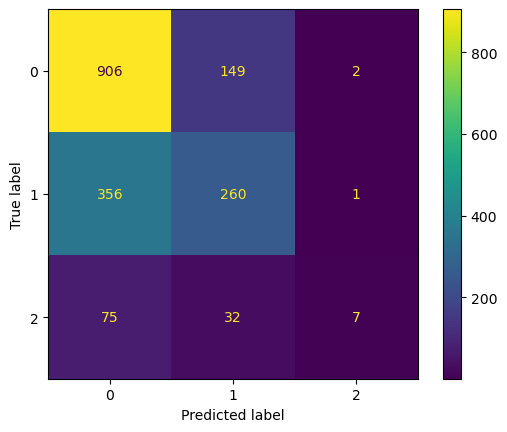

In [51]:
bn_model = BernoulliNB()
bn_model.fit(cv_X_train, y_train)
bn_pred = bn_model.predict(cv_X_test)

print(classification_report(y_test, bn_pred))

bn_cm = confusion_matrix(y_test, bn_pred)
ConfusionMatrixDisplay(bn_cm).plot()

In [52]:
print(bn_model.score(cv_X_train, y_train))
print(bn_model.score(cv_X_test, y_test))

0.7797985450475657
0.6560402684563759


In [64]:
roc_auc_score(y_test, bn_pred, average= None, multi_class = 'ovr')

AxisError: axis 1 is out of bounds for array of dimension 1

In [ ]:
fig, ax = plt.subplots()

RocCurveDisplay.from_estimator(bn_model, cv_X_test, y_test, ax = ax)
RocCurveDisplay.from_predictions(y_test, BN_pred ,ax=ax,name="Bernoilli Pred")

### Naive Bayes

In [74]:
from sklearn.naive_bayes import MultinomialNB

              precision    recall  f1-score   support

           0       0.69      0.81      0.75      1057
           1       0.57      0.47      0.51       617
           2       0.53      0.18      0.26       114

    accuracy                           0.65      1788
   macro avg       0.59      0.48      0.51      1788
weighted avg       0.64      0.65      0.63      1788



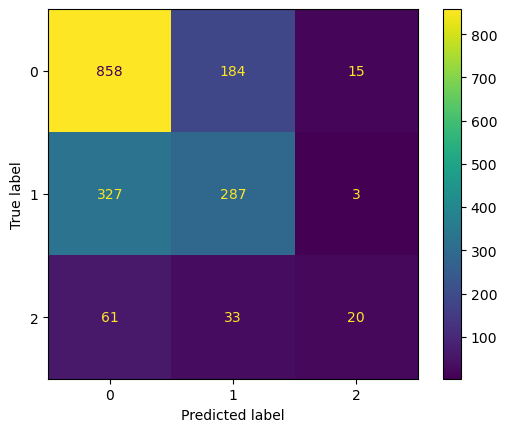

In [75]:
nb = MultinomialNB()
nb.fit(cv_X_train, y_train)
nb_pred = nb.predict(cv_X_test)

print(classification_report(y_test, nb_pred))

nb_cm = confusion_matrix(y_test, nb_pred)
ConfusionMatrixDisplay(nb_cm).plot()

In [76]:
print(nb.score(cv_X_train, y_train))
print(nb.score(cv_X_test, y_test))

0.799664241745943
0.651565995525727


In [ ]:
roc_auc_score(y_test, nb_pred)

In [ ]:
fig, ax = plt.subplots()

RocCurveDisplay.from_estimator(nb, cv_X_test, y_test, ax = ax)
RocCurveDisplay.from_predictions(y_test, nb_pred ,ax=ax,name="MultinomilaNB Pred")

### Compliment Naive Bayes

In [77]:
from sklearn.naive_bayes import ComplementNB

              precision    recall  f1-score   support

           0       0.73      0.70      0.72      1057
           1       0.56      0.57      0.56       617
           2       0.33      0.43      0.37       114

    accuracy                           0.64      1788
   macro avg       0.54      0.57      0.55      1788
weighted avg       0.65      0.64      0.64      1788



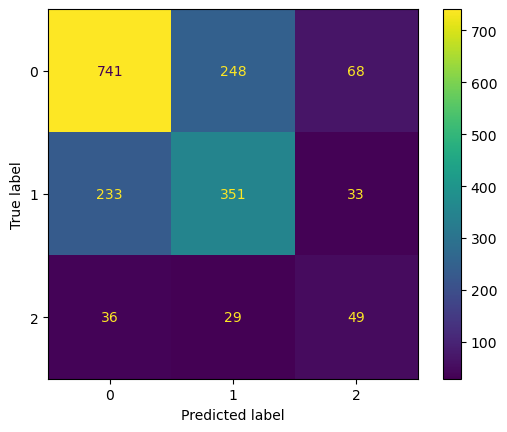

In [78]:
com_nb = ComplementNB()
com_nb.fit(cv_X_train, y_train)
com_pred = com_nb.predict(cv_X_test)

print(classification_report(y_test, com_pred))

com_cm = confusion_matrix(y_test, com_pred)
ConfusionMatrixDisplay(com_cm).plot()

In [79]:
print(com_nb.score(cv_X_train, y_train))
print(com_nb.score(cv_X_test, y_test))

0.7977056519306099
0.6381431767337807


In [ ]:
roc_auc_score(y_test, com_pred)

In [ ]:
fig, ax = plt.subplots()

RocCurveDisplay.from_estimator(com_nb, cv_X_test, y_test, ax = ax)
RocCurveDisplay.from_predictions(y_test, com_pred ,ax=ax,name="ComplementNB Pred")